In [9]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *
# Get 99% thickness
def get_L99(y,utilde):
    utilde = np.squeeze(utilde)
    du = abs(utilde[-1]-utilde[0])
    utop = 0.99*du/2.
    ubot = -0.99*du/2.
    Ny = np.size(y)
    ibot = np.argmin(abs(utilde[Ny/2:]-utop)[::-1])
    itop = np.argmin(abs(utilde[:Ny/2]-ubot)[::-1])+Ny/2
    #itop = np.argmin(abs(utilde[Ny/2:]-utop))+Ny/2
    #ibot = np.argmin(abs(utilde[:Ny/2]-ubot))
    L99 = y[itop]-y[ibot]
    if L99<0: print('utilde or y misoriented. exiting'); sys.exit()
    return L99, itop, ibot


In [22]:
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

dir_out = directory.split('/projects/ShockInducedMix/')[-1]
dir_out = '/home/kmatsuno/' + dir_out + '/'
print(dir_out)
flist = glob.glob(dir_out+"lscale_vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512//
['lscale_vv_0001.dat', 'lscale_vv_0002.dat', 'lscale_vv_0003.dat', 'lscale_vv_0004.dat', 'lscale_vv_0005.dat', 'lscale_vv_0006.dat', 'lscale_vv_0007.dat', 'lscale_vv_0008.dat', 'lscale_vv_0009.dat', 'lscale_vv_0010.dat', 'lscale_vv_0011.dat', 'lscale_vv_0012.dat', 'lscale_vv_0013.dat']


/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/
Mean, std: [0.554575614426, 0.00459769199948]


array([[0.79973324, 0.57908939, 0.4555337 , 0.46813139, 0.3295636 ,
        0.33655383, 0.29837725, 0.31933917, 0.29428125, 0.30589135,
        0.20253008, 0.22140113, 0.19941641],
       [1.10573601, 1.32688321, 1.99032481, 1.87975121, 2.21147201,
        2.65376641, 2.32204561, 2.65376641, 3.20663442, 2.98548721,
        3.64892882, 3.64892882, 3.98064962],
       [1.21907277, 1.28716008, 1.32140512, 1.34973834, 1.36617753,
        1.38610336, 1.40608748, 1.42391995, 1.42853966, 1.43461943,
        1.44018023, 1.44477028, 1.44334315],
       [0.72538232, 0.59696071, 0.68613328, 0.6519564 , 0.53347435,
        0.64434967, 0.49274714, 0.59515393, 0.66057135, 0.63656933,
        0.51314262, 0.55917331, 0.54997792]])

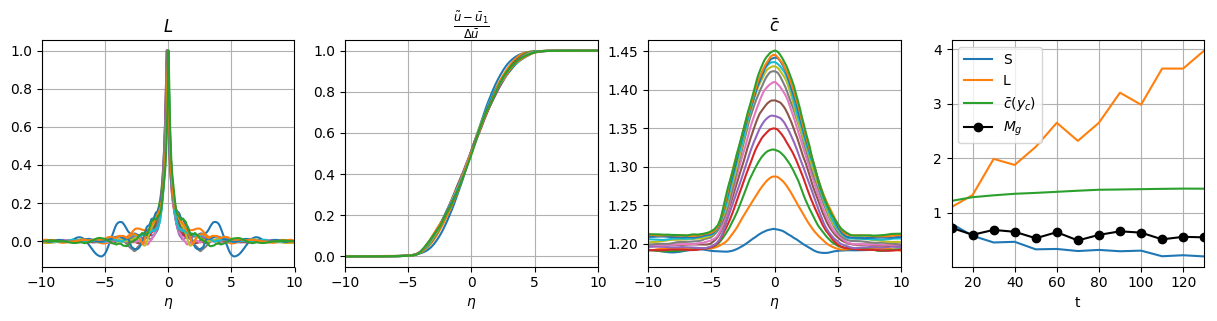

In [17]:

def plot_Mg(directory,inp,flist_plot,istat=0,savename=''):
    fig,ax = plt.subplots(1,4,figsize=(15,3), dpi=100)

    if len(flist_plot)>=15: flist_plot = flist_plot[::2]

    mat = np.zeros([4,len(flist_plot)])
    tlist = np.zeros(len(flist_plot))
    alpha = 1

    for count,fname in zip(range(len(flist_plot)),flist_plot):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)
        
        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta
        if (count==0 or count==len(flist_plot)-1):
            lbl = r't=%d ($\delta_{\theta}$=%0.2f)'%(time,dtheta)
        else: 
            lbl = 't=%d'%time

        # Get centerline
        ic,yc = get_centerline(directory,y,tID)

        # Get integral lengthscale
        autocorr = np.fromfile(fname, sep=' ')
        autocorr = np.reshape(autocorr,[Ny,3])
        autocorr = autocorr[:,0]
        L_int = get_lscale(y,autocorr,thresh=0.2)
        ax[0].plot(eta, autocorr, alpha=alpha,label=lbl)

        # Get shear S
        utilde = np.fromfile( directory + 'shearlayer_utilde_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
        offset = 2
        i1 = ic-offset
        i2 = ic+offset
        dy = y[i1]-y[i2]
        S = (utilde[i1]-utilde[i2])/dy  
        L99,i1,i2 = get_L99(y,utilde)
        ax[1].plot(eta, (utilde-utilde[0])/inp.du, alpha=alpha)

        # Get cbar
        cbar = np.fromfile( directory + 'shearlayer_cbar_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
        ax[2].plot(eta, cbar, alpha=alpha)        

        # Record for later
        Mg = S*L_int/cbar[ic]
        tlist[count] = time
        mat[0,count] = S
        mat[1,count] = L_int
        mat[2,count] = cbar[ic]
        mat[3,count] = Mg

    # Plot vs. time
    titles = ['S','L',r'$\bar{c}(y_c)$']
    for count, title in enumerate(titles[:]):
        ax[3].plot(tlist,mat[count,:],label=title)
    #ax2 = ax[3].twinx()
    ax[3].plot(tlist,mat[-1,:],'k-o',label=r'$M_g$')
    #ax[3].set_title(r'$M_g$')

    # Clean up plot
    xmax = L99/dtheta
    ax[0].set_title(r'$L$')
    ax[1].set_title(r'$\frac{\tilde{u}-\bar{u}_1}{\Delta \bar{u}}$')
    ax[2].set_title(r'$\bar{c}$')
    for a in ax:
        a.set_xlim([-xmax,xmax])
        a.grid(True)
        a.set_xlabel(r'$\eta$')
    ax[3].set_xlim([tlist[0],tlist[-1]])
    ax[3].legend()
    ax[3].set_xlabel('t')

    # set the overall title and save
    # fig.suptitle('Time: {}'.format(np.around(reader.time,-1)),size=fs,y=0.95)
    if savename:
        fig.savefig(savename, dpi=200,bbox_inches='tight')
        plt.close(fig)
        print "Saved plot to ",savename
    else: 
        print(directory)
        print("Mean, std: [{}, {}]".format(np.mean(mat[3,istat:]),np.std(mat[3,istat:])))
        fig.show()
    return mat

plot_Mg(directory,inp,flist[:],istat=-2,savename='')

In [24]:
s = '7'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    dir_out = directory.split('/projects/ShockInducedMix/')[-1]
    dir_out = '/home/kmatsuno/' + dir_out + '/'
    flist = glob.glob(dir_out+"lscale_vv*")    
    flist.sort()

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')

    # Plot Rij
    plot_Mg(directory,inp,flist[:],istat=0,savename=directory+'/img/Mg.png')
print('Done')

Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512//img/Mg.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512//img/Mg.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512//img/Mg.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512//img/Mg.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512//img/Mg.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512//img/Mg.png
Done
